# Deep Learning for Computer Vision:  HW 4

## Computer Science: COMS W 4995 005

### Due: October 31, 2024

### Problem

1. In this notebook we provide three networks for classifying handwritten digits from the MNIST dataset. The networks are implemented and tested using the Tensorflow framework. The third and final network is a convolutional neural network (CNN aka ConvNet) which achieves 99.18% accuracy on this dataset. 

    Your task is to re-implement all three networks using Pytorch. You will likely find several Pytorch implementations on the internet. It is ok to study these. However, you must not cut and paste this code into your assignment--you must write this yourself. Furthermore, you need to comment every line of code and succintly explain what it is doing! The MNIST dataset should be loadable from PyTorch/torchvision and part of your assignment is to find this and load it yourself.

    Here is what is required:

    a) A FULLY commented re-implementation of the networks below using Pytorch.

    b) your network trained on the same MNIST data as used here.

    c) an evaluation of the accuracy on the MNIST test set.

    d) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.

    e) have your training record a log of the validation loss and validation accuracy. 

    f) have your training continually save the best model so far (as determined by the validation loss).

    g) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

    Below we include the Tensorflow examples shown in class.  
   <p>&nbsp;</p> 


### A Simple Convolutional Neural Network in Tensorflow

This notebook covers a python and tensorflow-based solution to the handwritten digits recognition problem. It is based on tensorflow tutorials and Yann LeCun's early work on CNN's. This toturial compares a simple softmax regressor, a multi-layer perceptron (MLP), and a simple convolutional neural network (CNN).

Load in the MNIST digit dataset directly from tensorflow examples.

In [ ]:
%pip install numpy matplotlib pandas tensorflow sklearn

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). 

Let's import tensorflow and begin an interactive session.

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

## Softmax Regression Model on the MNIST Digits Data

We need to create placeholders for the data. Data will be dumped here when it is batched from the MNIST dataset.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Now let's see what this data looks like.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(4):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

We are first going to do softmax logistic regression. This is a linear layer followed by softmax. Note there are NO hidden layers here. Also note that the digit images (28x28 grayscale images) are reshaped into a 784 element vector. 

Below we create the parameters (weights) for our linear layer.

In [ ]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

We then use tensorflows initializer to initialize these weights.

In [ ]:
sess.run(tf.global_variables_initializer())

We create our linear layer as a function of the input and the weights.

In [ ]:
y_regressor = tf.matmul(x,W) + b

Below we create our loss function. Note that the cross entropy is $ H_{\hat{y}}(y) = -\sum_i \hat{y}_{i} \, \log(y_{i})$ where $\hat{y}$ is the true probability distribution and is expressed as a one-hot vector, $y$ is the estimated probability distribution, and $i$ indexes elements of these two vectors. Also note that this reduces to $ H_{\hat{y}}(y) = -\, \log(y_{i^*})$ where $i^*$ is the correct label. And if we sum this over all of our samples indexed by $j$, then $H_{\hat{y}}(y) = -\sum_j  \log(y^{(j)}_{i^*})$. This is precisely the same loss function as we used before, but we called the MLE loss. They are one and the same.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_regressor))

Now we tell tf to use gradient descent with a step size of 0.5 and to minimize the cross entropy.

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

We train by grabbing mini-batches with 100 samples each and pushing these through the network to update our weights (W and b).

In [ ]:
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

We define how to compute correct predicitions.

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_regressor,1), tf.argmax(y_,1))

And from these correct predictions how to compute the accuracy.

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Let's print out some test images and the corresponsing predictions made by the network. But first, let's add an output to the computation graph that computes the softmax probabilities.

In [ ]:
y_probs_regressor = tf.nn.softmax(logits=y_regressor, name=None)

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print ("Label = ", label)
    print ("Class probabilities = ", y_probs_regressor.eval(feed_dict={
        x: batch[0], y_: batch[1]}))

## Softmax Multi-Layer Perceptron on the MNIST Digits Data

Here we define both weight and bias variables and how they are to be initialized. Note that the weights are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we create placeholders for the training data.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

We create the first and only fully connected hidden layer.

In [ ]:
W_h = weight_variable([784, 512])
b_h = bias_variable([512])
h = tf.nn.relu(tf.matmul(x, W_h) + b_h)

We create the output layer.

In [ ]:
W_out = weight_variable([512, 10])
b_out = bias_variable([10])
y_MLP = tf.matmul(h, W_out) + b_out

We again use cross entropy loss on a softmax distribution on the outputs.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_MLP))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training. Note this softmax MLP network does quite a bit bettter than our softmax regressor. The non-linear layer really helps makes sense of the data! But we can do better still...

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_MLP,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1]})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

## A Simple Convolutional Neural Network: LeNet

Here we make our first CNN. It's quite simple network, but it's surprisingly good at this handwritten digit recognition task. This a variant on Yann LeCun's CNN network that really helped to move deep learning forward.

We define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLu. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we define how the convolution is to be computed and the extent and type of pooling. The convolution will use a 5x5 kernel and will pad the image with zeros around the edges and use a stride of 1 pixel so that the resulting image (after convolution) has the same size as the original input image. The network will learn the weights for a stack of 32 separate kernels along with 32 bias variables. Finally, after the ReLu is performed the result will be under go 2x2 max pooling, thus halfing both dimensions of the image. The choices for the stride, padding, and pooling are not parameters that the network needs to estimate. Rather these are termed "hyperparamters" that are usually set by the network designer.

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

This creates the weight and bias variables for the first convolutional layer as described above. Note the output has depth 32, so there will be 32 feature images after this layer.

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Unlike for our softmax regressor above, here we need keep the images as images and not collapse these into vectors; this allows us to perform the 2D convolution.

In [ ]:
x_image = tf.reshape(x, [-1,28,28,1])

Finally, we define are first layer of our CNN!

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

And wasting no time, we define are second layer. The second layer will have to process 32 feature images coming out of the first layer. Note that the images input to this layer have $\frac{1}{4}$ the number of pixels as the original input images due to the 2x2 pooling in the previous layer. Note that convolution layer NOT fully connected as our previous hidden layers have been. A unit in the output layer has a limited "receptive field." Its connections to the input layer are spatially limited by the kernel (or filter) size. Also, because of weight sharing in convolutional layers, the number of parameters for a convolutional is the size of the kernel x the depth of the input layer x depth of the output layer + depth of the output layer. So for the second layer of our ConvNet, we have 5 x 5 x 32 x 64 + 64 = 51,264 parameters. 

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

After the pooling stage of our second convolutional layer, we have 64 7x7 "feature" images. In one penultimate fully connected hidden layer, we are going to map these feature imges to a 1024 dimensional feature space. Note we need to flatten these feature images to do this.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout is added here, although it is not really needed for such small network.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

We have a final linear output layer mapping features to scores topped off with a softmax cross entropy loss function, as explained earlier.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training.

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

We add an output to compuational graph that computes the label probabilities.

In [ ]:
y_probs = tf.nn.softmax(logits=y_conv, name=None)

In [ ]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Next we step through some test examples and see how well the network is doing.

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print ("Label = ", label)
    print ("Class probabilities = ", y_probs.eval(feed_dict={
        x: batch[0], y_: batch[1], keep_prob: 1.0}))

## Implementing Softmax Regression Model on the MNIST Digits Data, Softmax Multi-Layer Perceptron on the MNIST Digits Data, CNN LeNet

- Instructions copied over using PyTorch/torchvision:
1) A FULLY commented re-implementation of the networks below using Pytorch.
2) your network trained on the same MNIST data as used here.
3) an evaluation of the accuracy on the MNIST test set.
4) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.
5) have your training record a log of the validation loss and validation accuracy. 
6) have your training continually save the best model so far (as determined by the validation loss).
7) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

### Softmax regression model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.5
batch_size = 100
num_epochs = 5

# Dataset and Dataloader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

# Initialize model, loss function, and optimizer
input_size = 28 * 28
num_classes = 10
model = SoftmaxRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Variables to keep track of the best model
best_val_loss = float('inf')
best_model_path = 'best_model.pth'

# Training and validation logging
training_log = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    running_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = running_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    
    # Logging the metrics for this epoch
    training_log['epoch'].append(epoch + 1)
    training_log['train_loss'].append(avg_train_loss)
    training_log['val_loss'].append(avg_val_loss)
    training_log['val_accuracy'].append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Check if this is the best model so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Load the best model
best_model = SoftmaxRegression(input_size, num_classes)
best_model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model on the test set
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the best model on the 10000 test images: {100 * correct / total:.2f}%')


Epoch [1/5], Train Loss: 4.0002, Val Loss: 3.2235, Val Accuracy: 77.37%
Best model saved with validation loss: 3.2235
Epoch [2/5], Train Loss: 1.5493, Val Loss: 0.9533, Val Accuracy: 89.48%
Best model saved with validation loss: 0.9533
Epoch [3/5], Train Loss: 1.4143, Val Loss: 1.0596, Val Accuracy: 88.50%
Epoch [4/5], Train Loss: 1.3656, Val Loss: 1.0105, Val Accuracy: 89.26%
Epoch [5/5], Train Loss: 1.3333, Val Loss: 1.3533, Val Accuracy: 85.79%


C:\Users\Rosh\AppData\Local\Temp\ipykernel_6320\3970282097.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


Accuracy of the best model on the 10000 test images: 89.48%


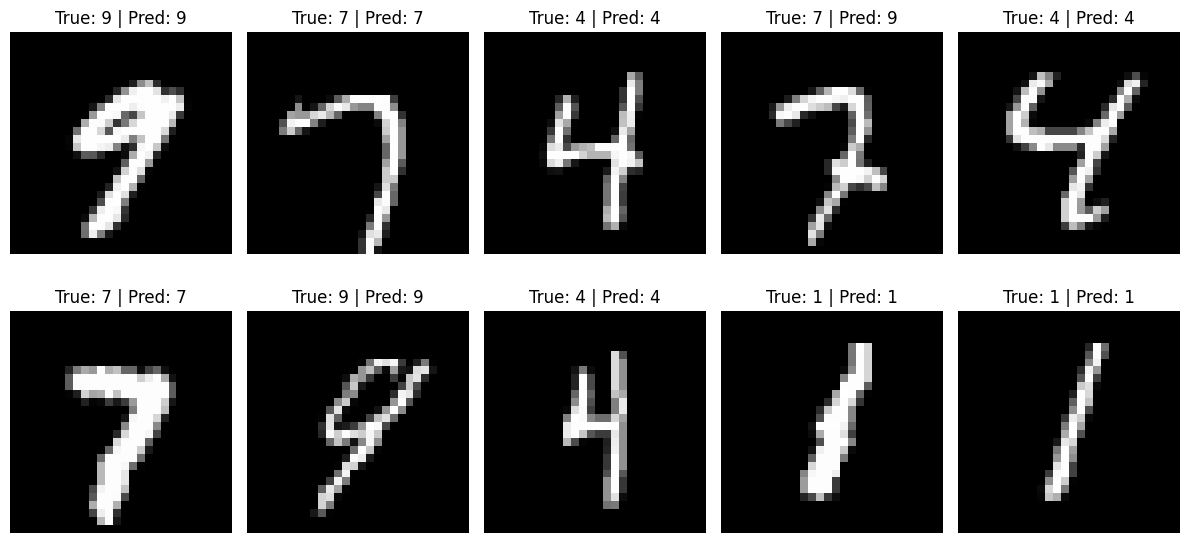

In [5]:
import random
import matplotlib.pyplot as plt

# Function to plot 10 random images with true and predicted labels
def plot_random_predictions(model, test_loader):
    # Set model to evaluation mode
    model.eval()

    # Get a batch of test data
    images, labels = next(iter(test_loader))

    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Select 10 random indices from the batch
    random_indices = random.sample(range(len(images)), 10)
    
    # Plot the images along with true and predicted labels
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(random_indices):
        img = images[idx].squeeze()  # Remove unnecessary dimensions
        label = labels[idx].item()
        pred_label = predicted[idx].item()
        
        plt.subplot(2, 5, i + 1)  # Arrange plots in a 2x5 grid
        plt.imshow(img, cmap='gray')  # Display image in grayscale
        plt.title(f'True: {label} | Pred: {pred_label}')
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Call the function with the model and test_loader
plot_random_predictions(model, test_loader)


### MLP

In [7]:
import torch
import torch.nn as nn  # Import neural network modules
import torch.optim as optim  # Import optimization algorithms
from torchvision import datasets, transforms  # Import dataset and transformations
from torch.utils.data import DataLoader, random_split  # For data loading and splitting

# Set hyperparameters
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 100  # Number of samples per batch
num_iterations = 20000  # Total number of training iterations

# Define data transformations: convert images to tensors and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize tensors to have mean 0.5 and std 0.5
])

# Load the full MNIST training dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the full training dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))  # Calculate training set size
val_size = len(full_train_dataset) - train_size  # Calculate validation set size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])  # Split dataset

# Create data loaders for training and validation datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Training data loader
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)  # Validation data loader

# Load the test dataset (used only for final evaluation)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Test data loader

# Calculate the number of epochs needed to reach the total number of iterations
iterations_per_epoch = len(train_loader)  # Number of batches per epoch
num_epochs = num_iterations // iterations_per_epoch + 1  # Total number of epochs

# Define a Multi-Layer Perceptron (MLP) model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # Define the first fully connected layer (input to hidden)
        self.fc1 = nn.Linear(input_size, hidden_size)  # Maps input features to hidden layer
        self.relu = nn.ReLU()  # Activation function introducing non-linearity
        # Define the second fully connected layer (hidden to output)
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Maps hidden layer to output classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten images from (batch_size, 1, 28, 28) to (batch_size, 784)
        x = self.fc1(x)  # Pass data through the first layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Pass data through the second layer
        return x  # Output raw scores (logits) for each class

# Initialize the model, loss function, and optimizer
input_size = 28 * 28  # Each image has 784 pixels
hidden_size = 128  # Increased hidden layer size for better performance
num_classes = 10  # Number of classes (digits 0-9)
model = MLP(input_size, hidden_size, num_classes)  # Create an instance of the MLP model

criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer for training

# Variables to keep track of the best model based on validation loss
best_val_loss = float('inf')  # Initialize best validation loss to infinity
best_model_path = 'best_model_mlp.pth'  # File path to save the best model weights

# Dictionary to record training and validation metrics
training_log = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Helper function to evaluate the model on validation or test data
def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm, etc.)
    running_loss = 0.0  # Sum of losses over the dataset
    correct = 0  # Number of correct predictions
    total = 0  # Total number of samples

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in data_loader:
            outputs = model(images)  # Forward pass to get outputs
            loss = criterion(outputs, labels)  # Compute loss
            running_loss += loss.item() * images.size(0)  # Accumulate weighted loss
            _, predicted = torch.max(outputs, 1)  # Get predicted class labels
            total += labels.size(0)  # Increment total samples
            correct += (predicted == labels).sum().item()  # Increment correct predictions

    avg_loss = running_loss / total  # Calculate average loss over all samples
    accuracy = 100 * correct / total  # Calculate accuracy percentage
    return avg_loss, accuracy  # Return average loss and accuracy

# Training loop
iterations = 0  # Counter for total iterations
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0  # Sum of training losses
    for images, labels in train_loader:
        # Forward pass: compute predicted outputs
        outputs = model(images)  # Get model predictions
        loss = criterion(outputs, labels)  # Compute loss between predictions and true labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from previous step
        loss.backward()  # Compute gradients of the loss w.r.t model parameters
        optimizer.step()  # Update model parameters

        running_train_loss += loss.item() * images.size(0)  # Accumulate weighted training loss
        iterations += 1  # Increment iteration count

        # Check if the desired number of iterations is reached
        if iterations >= num_iterations:
            break  # Exit the batch loop
    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_loader.dataset)

    # Evaluate the model on the validation set
    avg_val_loss, val_accuracy = evaluate_model(model, val_loader)

    # Record metrics in the training log
    training_log['epoch'].append(epoch + 1)
    training_log['train_loss'].append(avg_train_loss)
    training_log['val_loss'].append(avg_val_loss)
    training_log['val_accuracy'].append(val_accuracy)

    # Print epoch metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the model if it has the best validation loss so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Update best validation loss
        torch.save(model.state_dict(), best_model_path)  # Save model weights
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

    # Break the epoch loop if desired iterations are reached
    if iterations >= num_iterations:
        break  # Exit the epoch loop

# Load the best model weights after training
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model on the test set
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f'Best model evaluation on test set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')


Epoch [1/42], Train Loss: 0.4321, Val Loss: 0.2797, Val Accuracy: 91.82%
Best model saved with validation loss: 0.2797
Epoch [2/42], Train Loss: 0.2406, Val Loss: 0.2142, Val Accuracy: 93.78%
Best model saved with validation loss: 0.2142
Epoch [3/42], Train Loss: 0.1734, Val Loss: 0.1707, Val Accuracy: 94.83%
Best model saved with validation loss: 0.1707
Epoch [4/42], Train Loss: 0.1366, Val Loss: 0.1383, Val Accuracy: 95.85%
Best model saved with validation loss: 0.1383
Epoch [5/42], Train Loss: 0.1144, Val Loss: 0.1234, Val Accuracy: 96.22%
Best model saved with validation loss: 0.1234
Epoch [6/42], Train Loss: 0.0973, Val Loss: 0.1302, Val Accuracy: 95.99%
Epoch [7/42], Train Loss: 0.0845, Val Loss: 0.1072, Val Accuracy: 96.88%
Best model saved with validation loss: 0.1072
Epoch [8/42], Train Loss: 0.0747, Val Loss: 0.0965, Val Accuracy: 97.07%
Best model saved with validation loss: 0.0965
Epoch [9/42], Train Loss: 0.0664, Val Loss: 0.1091, Val Accuracy: 96.67%
Epoch [10/42], Train 

C:\Users\Rosh\AppData\Local\Temp\ipykernel_6320\569634042.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Best model evaluation on test set - Loss: 0.0857, Accuracy: 97.43%


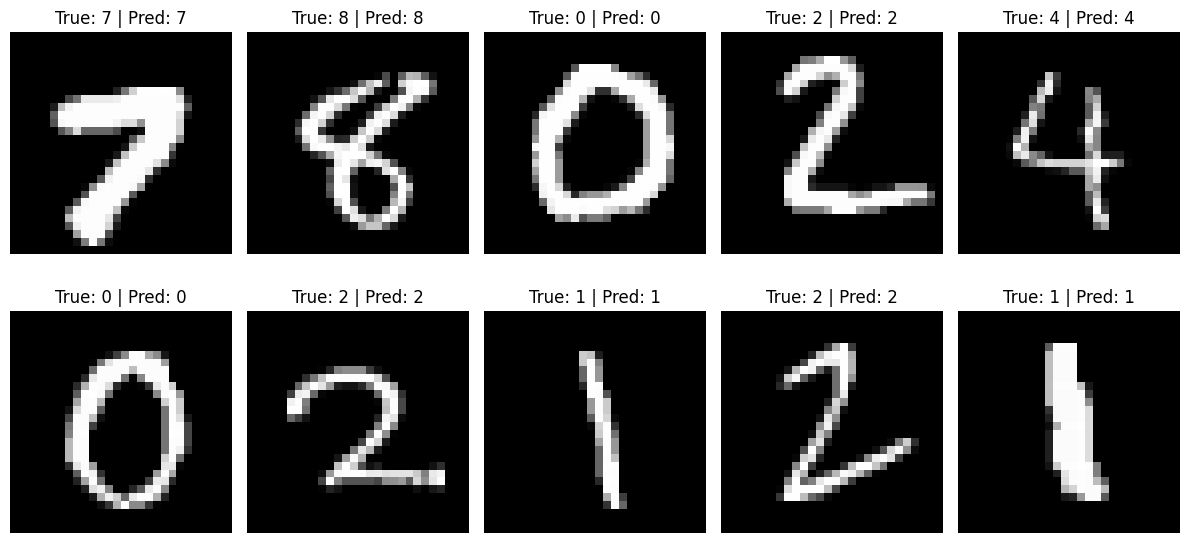

In [8]:
plot_random_predictions(model, test_loader)

In [9]:
### CNN LeNet